# Time Zero Analysis and Correction

!!! Needs updating!!!

This notebook uses the .h5 file data saved when running the `process_all.py` file. It looks at the time zero fitting for each dataset in the .h5 file. For example, I run the `process_all.py` file with groups of ~ 200 then I will use each data set and fit it with an error function. 

In [1]:
import numpy as np
import gued
import matplotlib.pyplot as plt
import scipy.optimize
import scipy

## Load Experimental Data

Can specify which subsets of data to use based on the `run_numbers` variable and look for drifts related to lab time as the data stored in the .h5 file is sorted with respect to lab time

In [ ]:
file_name = 'o-ntph_data_2024-07-11.h5'
group_name = "s1"
run_numbers = list(np.arange(0,8,1)) 
# Don't read in the raw data (clean_images) unless you are not reading all images
variable_names = ["I", "centers", 
                  "percent_outliers", "percent_xrays", 
                  "stage_positions", "total_counts"]

### Load runs

In [ ]:
# Read combined data
combined_data = gued.read_combined_data(file_name, group_name, variable_names, run_numbers=run_numbers)
print(combined_data.keys())
combined_I = combined_data['I']
combined_stage = combined_data['stage_positions']
combined_centers = combined_data['centers']
print(combined_centers[0].shape)

dict_keys(['I', 'stage_positions', 'centers'])
(2,)


### Remove any additional images based on index

For problem images that weren't removed in the preprocessing but that are disrupting the data.

In [20]:
print(np.where(combined_stage==108.81)[0])


[  32   68   87  110  159  202  229  268  280  323  374  412  456  493
  506  544  607  630  682  703  753  771  821  844  892  905  948  978
 1040 1079 1114 1155 1193 1207 1237 1286 1343 1349 1385 1453 1486 1527
 1544 1569 1606 1656 1696]


In [21]:
bad_idx = np.where(combined_stage==154.72)[0]

bad_idx = [374]
print(bad_idx)
mask = np.ones(combined_stage.shape, dtype=bool)
mask[bad_idx] = False

combined_stage = combined_stage[mask]
combined_I = combined_I[mask]

[374]


## Set Up Independent variables

In [30]:
uni_stage = uni_stage = np.unique(combined_stage) # Pump-probe stage position
s_cali = 0.0226 # S calibration in experiment
#s_cali = 0.02134
posi_0    = 154.405 # The reference T0
#posi_0 = 108.61
s = np.arange(0,len(combined_I[0]))*s_cali # The Q axis
realtime = (uni_stage-posi_0)/0.15  # Delay axis in ps

## Averaging Based on Delay Position

In [31]:
stage_len = len(uni_stage);               #  Number of delays
azimuthal_data = np.ones((stage_len, len(combined_I[0]))); #  Delay dependent averaged pp images

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    stage_data = combined_I[np.where(combined_stage==uni_stage[i])[0]];
    azimuthal_data[i] = np.nanmean(stage_data,axis=0); # no subtracting background


Averaging data at stage posi # 0, 153.0 mm
Averaging data at stage posi # 5, 154.375 mm
Averaging data at stage posi # 10, 154.425 mm
Averaging data at stage posi # 15, 154.475 mm
Averaging data at stage posi # 20, 154.525 mm
Averaging data at stage posi # 25, 154.6 mm
Averaging data at stage posi # 30, 154.795 mm
Averaging data at stage posi # 35, 157.5 mm


C:\Users\laure\AppData\Local\Temp\ipykernel_23012\1352326992.py:12: RuntimeWarning: Mean of empty slice
  azimuthal_data[i] = np.nanmean(stage_data,axis=0); # no subtracting background


## Set Up Integrated Data

Create groups to fit over, two to three peaks works well. I use three

In [32]:
if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 3
norm_ref = np.nanmean(azimuthal_data[:N_ref],axis=0)         # Reference signal before T0

dI_I = (azimuthal_data-norm_ref)/norm_ref # Calculate the percentage difference signal

dI_I_fit = gued.poly_fit(dI_I, s, plot=False)
#dI_I_fit = dI_I


# Range s values to integrate over
RoI_1 = [2.0, 2.4]
RoI_2 = [3.0, 3.5]
RoI_3 = [4.2, 4.8]

# Averaged signal within the ranges of interest
Inte_1 = np.nanmean(dI_I_fit[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)], axis=1)
Inte_2 = np.nanmean(dI_I_fit[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)], axis=1)
Inte_3 = np.nanmean(dI_I_fit[:, round(RoI_3[0]/s_cali):round(RoI_3[1]/s_cali)], axis=1)

C:\Users\laure\AppData\Local\Temp\ipykernel_23012\2926092893.py:5: RuntimeWarning: Mean of empty slice
  norm_ref = np.nanmean(azimuthal_data[:N_ref],axis=0)         # Reference signal before T0


## Plot dI/I

C:\Users\laure\AppData\Local\Temp\ipykernel_23012\396809681.py:13: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


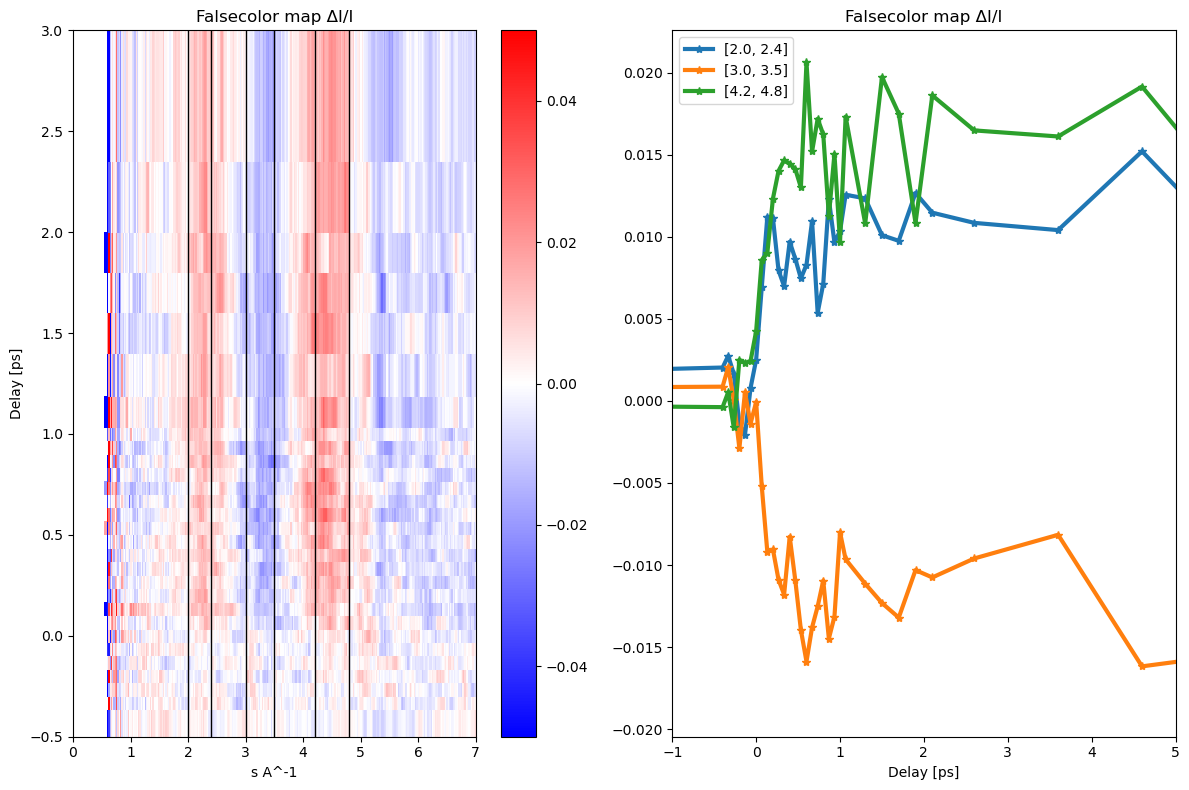

In [33]:
# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.pcolor(s,realtime,dI_I_fit,cmap='bwr')
plt.axvline(x = RoI_1[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_1[1], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_2[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_2[1], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_3[0], color = 'k', linestyle = '-',linewidth=1)
plt.axvline(x = RoI_3[1], color = 'k', linestyle = '-',linewidth=1)
plt.clim(vmin=-0.05, vmax=0.05)
plt.colorbar()
plt.ylim(-0.5, 3)
plt.xlim(0, 7)
plt.xlabel('s A^-1')
plt.ylabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.subplot(1,2,2)
plt.plot(realtime, Inte_1, '-*', linewidth=3, label=str(RoI_1))
plt.plot(realtime, Inte_2, '-*', linewidth=3, label=str(RoI_2))
plt.plot(realtime, Inte_3, '-*', linewidth=3, label=str(RoI_3))
plt.xlim(-1, 5)
plt.legend()
plt.xlabel('Integrated Yield [arb.]')
plt.xlabel('Delay [ps]')
plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()


## T0 Fitting

I'm using the absolute value of 3 main peaks and the absolute value of all the data for multiple t0 fits in case of delay between structural motion and laser pump. 

Fit parameters: 
t_0 = 0.069 ps +/- 0.02 ps
sigma = 0.240 ps +/- 0.06 ps
offset = 0.019




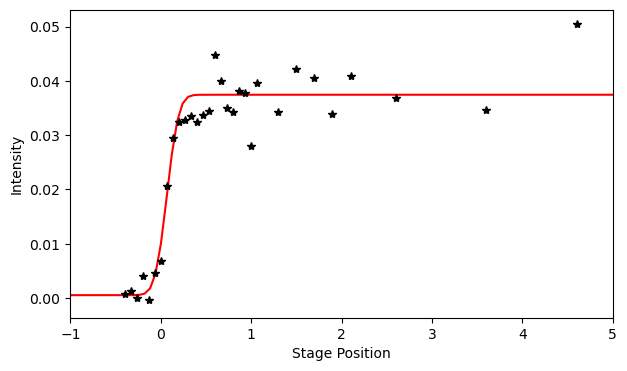

Fit parameters: 
t_0 = 0.068 ps +/- 11163.23 ps
sigma = 0.026 ps +/- 188768.60 ps


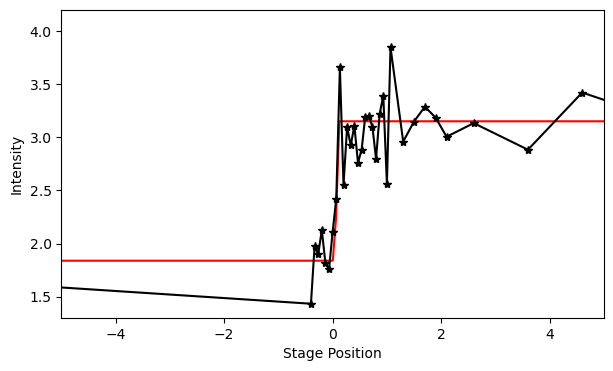

In [48]:
# Fit the curve to the data

three_peaks = Inte_1 + (-1*Inte_2) + Inte_3
all_data = np.nansum(np.abs(dI_I_fit), axis=1)
all_azimuthal = gued.normalize_to_range(azimuthal_data, min_val=0, max_val=1)
all_azimuthal = np.nanmean(np.abs(all_azimuthal), axis=1)
#all_azimuthal = gued.normalize_to_range(all_azimuthal, min_val=0, max_val=1)


# Define the error function using scipy.special.erf
def error_function(t, a, t0, sigma, offset):
    return a * scipy.special.erf((t-t0)/(sigma/(np.sqrt(2*np.log(2))))*np.sqrt(2)) + offset


# Define bounds for the parameters [amplitude, t0, sigma, offset]
bounds = ([-1, -0.5, 0, -0.001], [1, 1, 1.5, 0.1])  # lower bounds, upper bounds
guesses = [0.01, 0.5, 0.5, 0.0]

# Fit 3 peaks of data
popt, pcov = scipy.optimize.curve_fit(error_function, realtime[:], three_peaks[:], p0=guesses, bounds=bounds)

t_new = np.linspace(realtime[0], realtime[-1], 1000)
stage_new = np.linspace(uni_stage[0], uni_stage[-1], 1000)
## error func fit
A, t0, sigma, offset = popt
#A1, t1, sigma1, offset1 = popt_all
print("Fit parameters: ")
print("=====================================================")

print(f"t_0 = {popt[1]:.3f} ps +/- {np.sqrt(pcov[1,1]):.2f} ps")
print(f"sigma = {popt[2]:.3f} ps +/- {np.sqrt(pcov[2,2]):.2f} ps")
print(f"offset = {popt[3]:.3f}")

print("\n")
plt.figure(figsize=(7,4))
plt.plot(t_new, error_function(t_new, A, t0, sigma, offset) ,color='red', label="fit")
plt.plot(realtime, three_peaks, "*", color='black')
#plt.xlim(-1,2)
plt.xlim(-1, 5)
plt.xlabel("Stage Position")
plt.ylabel("Intensity")
#plt.title("UED IRF Fit")
#plt.legend()
plt.show()

# Define bounds for the parameters [amplitude, t0, sigma, offset]
bounds = ([-4, -0.5, 0, -4], [5, 1, 2, 5])  # lower bounds, upper bounds
guesses = [0.01, 0.5, 0.5, 4]


# Fit the curve to all dI/I data
popt, pcov = scipy.optimize.curve_fit(error_function, realtime[:], all_data[:], p0=guesses, bounds=bounds)

t_new = np.linspace(realtime[0], realtime[-1], 1000)
stage_new = np.linspace(uni_stage[0], uni_stage[-1], 1000)
## error func fit
A, t0, sigma, offset = popt
#A1, t1, sigma1, offset1 = popt_all
print("Fit parameters: ")
print("=====================================================")

print(f"t_0 = {popt[1]:.3f} ps +/- {np.sqrt(pcov[1,1]):.2f} ps")
print(f"sigma = {popt[2]:.3f} ps +/- {np.sqrt(pcov[2,2]):.2f} ps")

plt.figure(figsize=(7,4))
plt.plot(t_new, error_function(t_new, A, t0, sigma, offset) ,color='red', label="fit")
plt.plot(realtime, all_data, "-*", color='black')
#plt.xlim(-1,2)
plt.xlim(-5, 5)
plt.xlabel("Stage Position")
plt.ylabel("Intensity")
#plt.title("UED IRF Fit")
#plt.legend()
plt.show()

